In [129]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

In [130]:
pillbox = np.load('images/pillbox.npy')
test = np.load('images/test.npy')
line = np.load('images/line.npy')

In [131]:
def color_models_comparison(img):
    # Plot different color models
    rgb = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    rgb_dict = {'rgb': rgb, 'red': rgb[..., 0], 'green': rgb[..., 1], 'blue': rgb[..., 2]}
    hsv_dict = {'hsv': hsv, 'hue': hsv[..., 0], 'saturation': hsv[..., 1], 'value': hsv[..., 2]}
    hls_dict = {'hls': hls, 'hue': hls[..., 0], 'lightness': hls[..., 1], 'saturation': hls[..., 2]}
    lab_dict = {'lab': lab, 'L*': lab[..., 0], 'a*': lab[..., 1], 'b*': lab[..., 2]}
    dicts = [rgb_dict, hsv_dict, hls_dict, lab_dict]

    _, axs = plt.subplots(4, 4, figsize = (12, 10))
    for i, dct in enumerate(dicts):
        for j, (k, v) in enumerate(dct.items()):
            axs[i][j].imshow(v, cmap = 'gray')
            axs[i][j].set_title(k)
            axs[i][j].axis('off')
    plt.show()

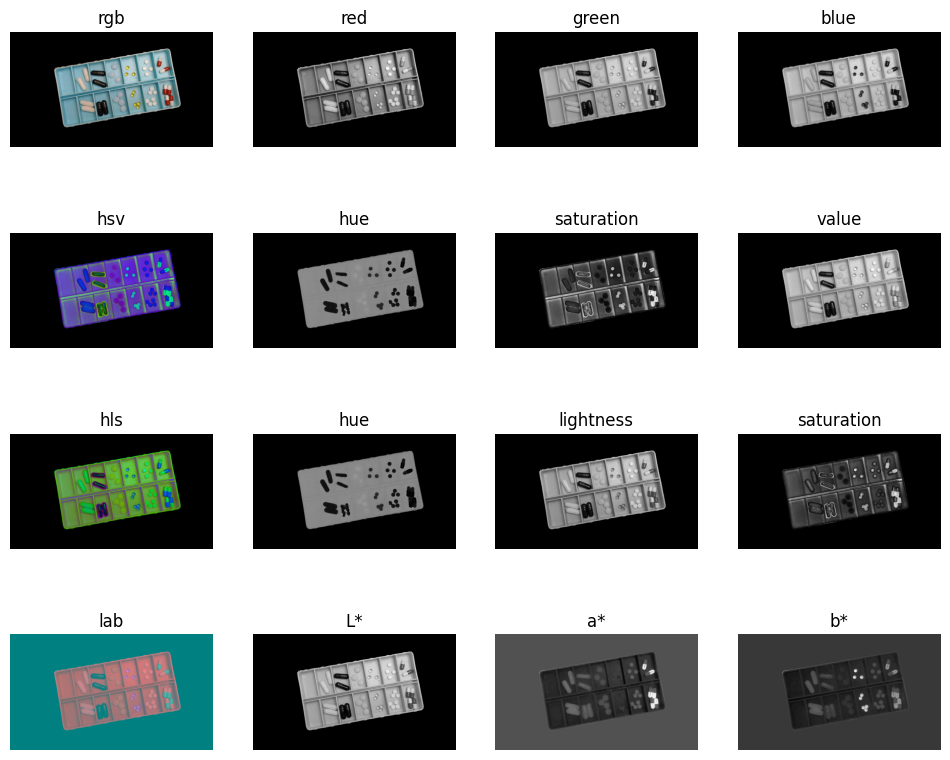

In [132]:
color_models_comparison(pillbox)

### PROBIO

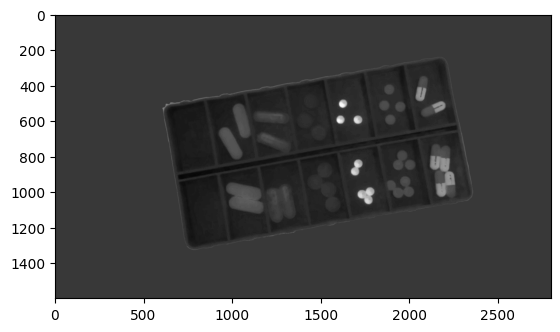

In [233]:
test3 = cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 2]
plt.imshow(test3, cmap = 'gray')

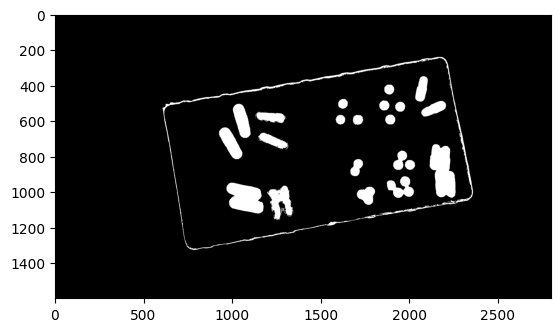

In [279]:
plt.imshow(cv2.threshold(test3, 128, 255, cv2.THRESH_BINARY)[1], cmap  = 'gray')
lol = cv2.threshold(test3, 130, 255, cv2.THRESH_BINARY)[1]

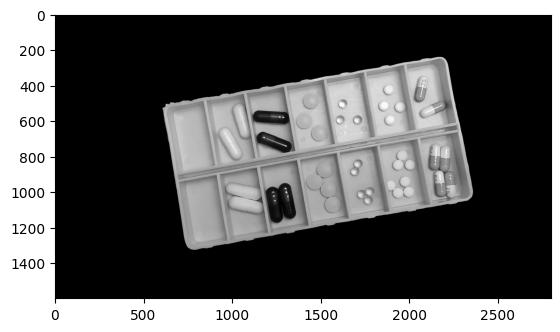

In [259]:
# test1 = cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 1]
test1 = cv2.cvtColor(pillbox, cv2.COLOR_RGB2HSV)[..., 2]
plt.imshow(test1, cmap = 'gray')

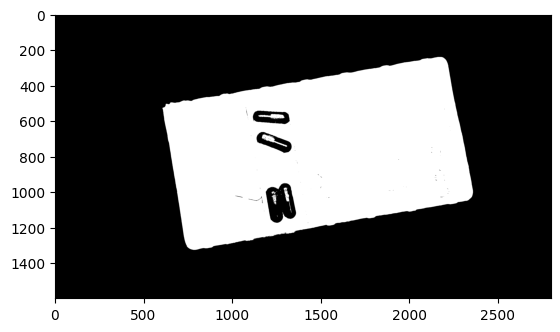

In [260]:
_, binary = cv2.threshold(test1, 45, 255, type = cv2.THRESH_BINARY)

plt.imshow(binary, cmap = 'gray')

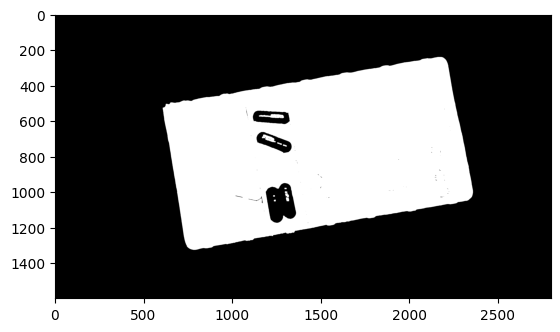

In [261]:
# # noise removal
kernel = np.ones((3, 3), np.uint8)
bin_img = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations = 3)
plt.imshow(bin_img, cmap = 'gray')

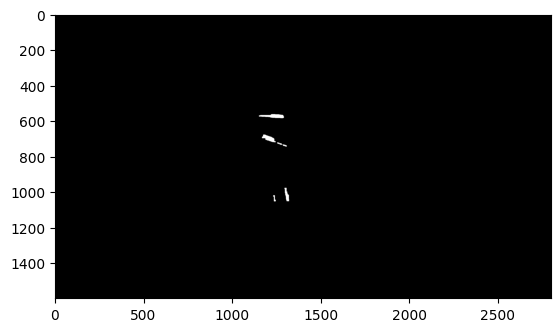

In [262]:
num_labels, labels = cv2.connectedComponents(bin_img, connectivity= 4)
sizes = np.bincount(labels.ravel())
box_idx = np.argmax(sizes[1:]) + 1
bin_img2 = bin_img.copy()

bin_img2[labels == box_idx] = 0
bin_img2 = cv2.morphologyEx(bin_img2, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 24)

plt.imshow(bin_img2, cmap = 'gray')

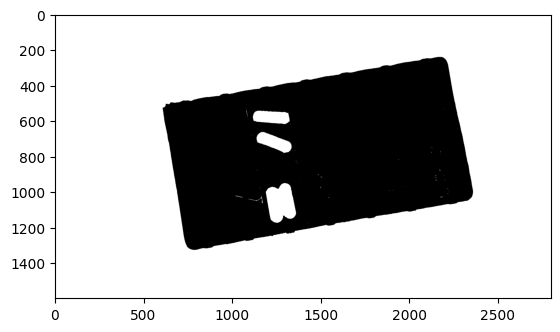

In [263]:
bin_img3 = bin_img.copy()
bin_img3[bin_img2 == 255] = 0
plt.imshow(~bin_img3, cmap = 'gray')

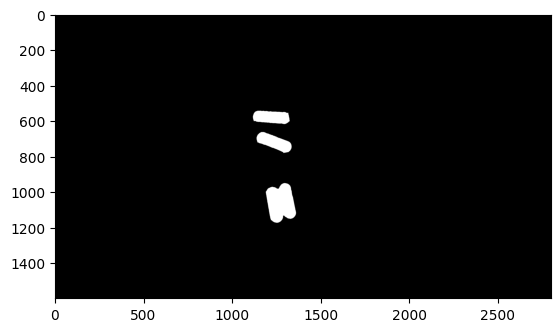

In [264]:
num_labels, labels = cv2.connectedComponents(~bin_img3, connectivity= 4)
sizes = np.bincount(labels.ravel())
sizess = sizes[2:]
labelss = np.array(list(set(list(labels.flatten())))[2:])
dct = dict(zip(labelss, sizess))
dcttt = {k: v for k, v in dct.items() if v > 10000}

bin_img4 = ~bin_img3.copy()
bin_img4[~np.isin(labels, list(dcttt.keys()))] = 0
plt.imshow(bin_img4, cmap = 'gray')

In [266]:
_, lll = cv2.connectedComponents(bin_img4, connectivity=4)
sss = np.bincount(lll.ravel())
sss

array([4427122,   12633,   12742,   27503])

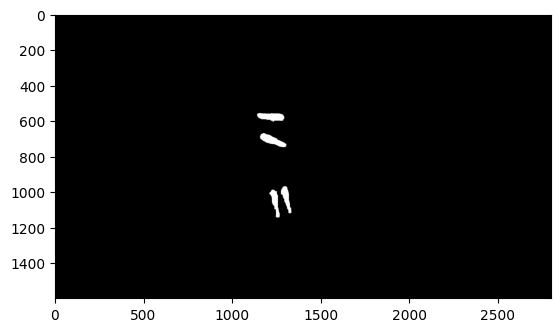

In [268]:
lolxd = bin_img4.copy()
lolxd[lol == 0] = 0
lolxd = cv2.morphologyEx(lolxd, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 10)
plt.imshow(lolxd, cmap = 'gray')

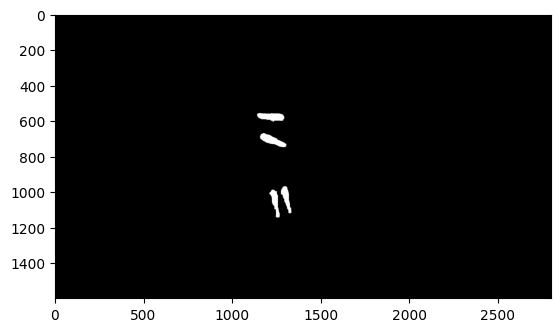

In [280]:
plt.imshow(lolxd, cmap = 'gray')

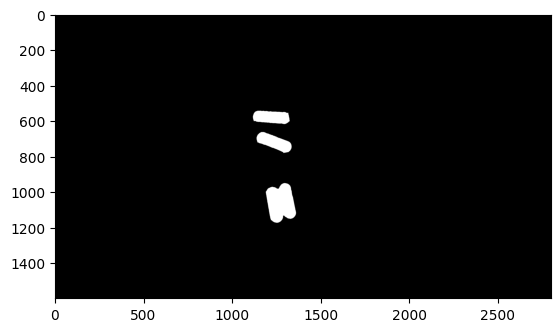

In [281]:
plt.imshow(bin_img4, cmap = 'gray')

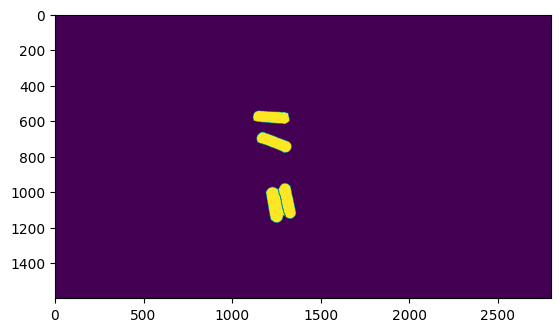

In [283]:
num_labels, markers = cv2.connectedComponents(lolxd, connectivity= 4)
color_full_image = bin_img4.copy()

cv2.watershed(cv2.merge([color_full_image] * 3), markers)
color_full_image[markers == -1] = 0

color_full_image = cv2.erode(color_full_image, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)

plt.imshow(color_full_image)

num_labels, markers = cv2.connectedComponents(color_full_image, connectivity= 4)
sizes = np.bincount(markers.ravel())
max(sizes)

In [ ]:
def detect_carbon(dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.cvtColor(dest_img, cv2.COLOR_RGB2HSV)[..., 2]
    
    _, t = cv2.threshold(GRAY, 45, 255, type = cv2.THRESH_BINARY)
    morph_img = cv2.morphologyEx(t, 
                                 cv2.MORPH_OPEN, 
                                 np.ones((3, 3), np.uint8), 
                                 iterations = 3)
    
    _, labels = cv2.connectedComponents(morph_img, connectivity = 4)
    sizes = np.bincount(labels.ravel())
    box_idx = np.argmax(sizes[1:]) + 1
    shine = morph_img.copy()
    shine[labels == box_idx] = 0
    
    removed_shine = morph_img.copy()
    removed_shine[shine == 255] = 0
    
    _, labels2 = cv2.connectedComponents(~removed_shine, connectivity = 4)
    sizes2 =  np.bincount(labels2.ravel())
    sizess = sizes2[2:]
    labelss = np.array(list(set(list(labels2.flatten())))[2:])
    dct = dict(zip(labelss, sizess))
    filtered_dct = {k: v for k, v in dct.items() if v > 10000}
    
    just_pills = ~removed_shine.copy()
    just_pills[~np.isin(labels2, list(filtered_dct.keys()))] = 0
    
    _, labels3 = cv2.connectedComponents(just_pills, connectivity = 4)

    if max(np.bincount(labels3.ravel())) > 15000:
        lab = cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 2]
        t_lab = cv2.threshold(lab, 130, 255, cv2.THRESH_BINARY)[1]
        erode = just_pills.copy()
        erode[t_lab == 0] = 0
        eroded_pills = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 10)
        _, markers = cv2.connectedComponents(eroded_pills, connectivity= 4)
        
        color_full_image = just_pills.copy()
        cv2.watershed(cv2.merge([color_full_image] * 3), markers)
        color_full_image[markers == -1] = 0
        color_full_image = cv2.erode(color_full_image, kernel = np.ones((3, 3), np.uint8), anchor = (-1, -1), borderType = cv2.BORDER_REPLICATE)
        just_pills = color_full_image.copy()
        
    contours, _ = cv2.findContours(just_pills, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(dest_img, contours, -1, (255, 105, 180), 3)
        
    plt.imshow(dest_img)

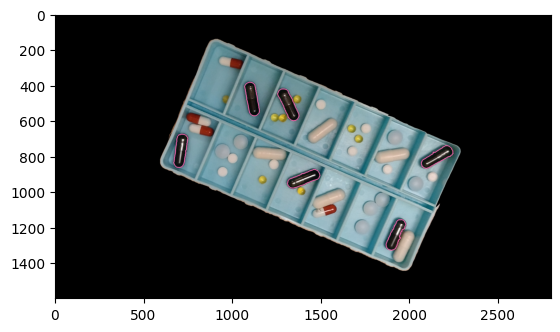

In [316]:
detect_carbon(line)

## Biała piguła

In [370]:
def detect_biox(roi, dest_img):
    dest_img = dest_img.copy()
    
    GRAY = roi[..., 0]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 5, param2 = 30,
                                minRadius = 26, maxRadius = 33)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 0, 255), 3)

    return dest_img, CIRCLES

def detect_epsu(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.threshold(cv2.cvtColor(roi, cv2.COLOR_RGB2LAB)[..., 2], 167, 255, cv2.THRESH_BINARY)[1]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 30, param2 = 7,
                                minRadius = 3, maxRadius = 25)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 255, 0), 3)

    return dest_img, CIRCLES

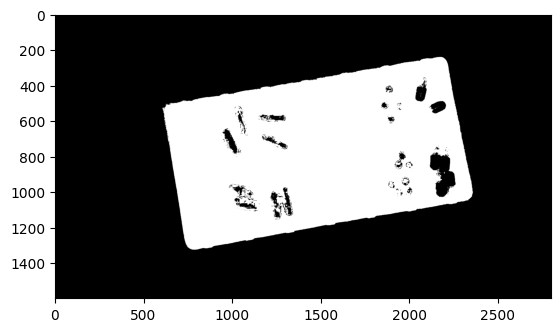

In [362]:
plt.imshow(cv2.threshold(cv2.cvtColor(pillbox, cv2.COLOR_RGB2HSV)[..., 0], 12, 255, cv2.THRESH_BINARY)[1], cmap = 'gray')

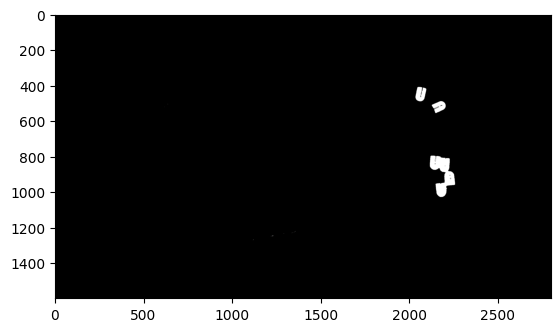

In [360]:
plt.imshow(cv2.threshold(cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 1], 145, 255, cv2.THRESH_BINARY)[1], cmap = 'gray')

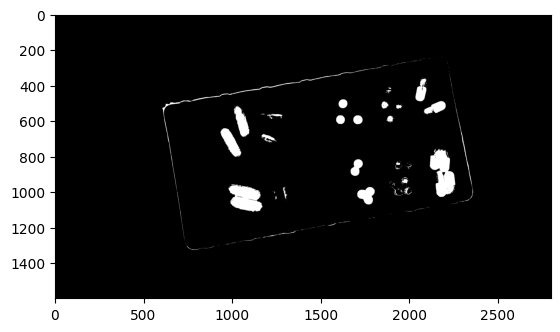

In [369]:
plt.imshow(cv2.threshold(cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 2], 135, 255, cv2.THRESH_BINARY)[1], cmap = 'gray')